- 设置工作目录到项目根目录，确保相对路径（`models/` 等）可用。
- 固定随机种子，选择计算设备（GPU优先）。


In [51]:
import os
import sys
import numpy as np
import torch
from matplotlib import pyplot as plt

# Ensure working directory is project root (adjust if needed)
project_root = os.path.abspath(os.path.join(os.path.dirname("..")))
os.chdir(project_root)
print(f"CWD: {os.getcwd()}")

# Global seed and device
seed = np.random.RandomState(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


CWD: z:\WorkSpace\osd-cnn\notebooks
Device: cuda


- 生成/加载校验矩阵 `H` 与生成矩阵 `G`，打印 `(n, k)` 与码率。
- 设置全局参数：`USE_APP_LLR_FOR_OSD`、`max_iter_nms`、训练SNR、batch大小等。
- 指定模型保存路径 `models/dia_cnn.pth`。


In [52]:
import torch.nn as nn
import torch.optim as optim
from pyldpc import make_ldpc, encode, decode, get_message
from torch.utils.data import DataLoader, TensorDataset

# LDPC code params
n = 128
d_v = 4
d_c = 8
H, G = make_ldpc(n, d_v, d_c, seed=seed, systematic=True, sparse=True)
n_code, k_info = G.shape
print(f"LDPC: n={n_code}, k={k_info}, R={k_info/n_code:.2f}")

# Global configs
USE_APP_LLR_FOR_OSD = False
max_iter_nms = 12
snr_train_db = 2.7
epochs = 20
batch_size = 256

# Model path
model_dir = os.path.join("models")
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "dia_cnn.pth")


LDPC: n=128, k=67, R=0.52


- 构建Tanner图邻接，执行规范化最小和（NMS）迭代。
- 支持综合校验早停。`alpha` 可按论文调整。


In [53]:
import numpy as np

def decode_with_trajectory(H, y, snr, max_iter):
    m_checks, n_vars = H.shape

    # --- Tanner图邻接表构建 ---
    if hasattr(H, 'toarray'): 
        H_dense = H.toarray()
        rows, cols = H.nonzero()
    else: 
        H_dense = H
        rows, cols = np.nonzero(H)
    
    var_to_checks = [[] for _ in range(n_vars)]
    check_to_vars = [[] for _ in range(m_checks)]
    for r, c in zip(rows, cols):
        var_to_checks[c].append(r)
        check_to_vars[r].append(c)

    # --- 初始LLR计算 ---
    R = float(k_info) / float(n_code)
    EbN0_linear = 10.0 ** (float(snr) / 10.0)
    channel_llr = 4.0 * R * EbN0_linear * y.astype(float)
    
    llrs_trajectory = np.zeros((n_vars, max_iter + 1), dtype=float)
    llrs_trajectory[:, 0] = channel_llr

    # --- 消息初始化 ---
    # v2c: 变量到校验的消息，初始化为信道LLR
    v2c_msgs = np.zeros((m_checks, n_vars), dtype=float)
    for v_idx in range(n_vars):
        for c_idx in var_to_checks[v_idx]:
            v2c_msgs[c_idx, v_idx] = channel_llr[v_idx]
    
    # c2v: 校验到变量的消息，初始化为0
    c2v_msgs = np.zeros((m_checks, n_vars), dtype=float)
    alpha = 0.8

    # --- 迭代更新 ---
    for it in range(1, max_iter + 1):
        
        # ======================= 关键逻辑修正 =======================
        # 阶段一：校验节点更新 (计算 c2v)
        # 使用来自上一轮的 v2c_msgs
        # ============================================================
        for c in range(m_checks):
            connected_vars = check_to_vars[c]
            if not connected_vars: continue

            incoming_v2c = [v2c_msgs[c, v] for v in connected_vars]
            
            for i, v_target in enumerate(connected_vars):
                other_msgs = incoming_v2c[:i] + incoming_v2c[i+1:]
                
                if not other_msgs:
                    c2v_msgs[c, v_target] = 0.0
                    continue

                signs = np.sign(other_msgs)
                abs_values = np.abs(other_msgs)
                
                sign_prod = np.prod(signs)
                min_abs = np.min(abs_values)
                
                c2v_msgs[c, v_target] = alpha * sign_prod * min_abs

        # ============================================================
        # 阶段二：变量节点更新 (计算 a_posteriori 和下一轮的 v2c)
        # 使用刚刚在本轮计算出的 c2v_msgs
        # ============================================================
        a_posteriori = channel_llr + np.sum(c2v_msgs, axis=0)
        llrs_trajectory[:, it] = a_posteriori

        # 计算下一轮要用的 v2c 消息 (外信息)
        for v in range(n_vars):
            for c in var_to_checks[v]:
                 v2c_msgs[c, v] = a_posteriori[v] - c2v_msgs[c, v]

        # --- 早停判断 ---
        hard_bits = (a_posteriori < 0).astype(int)
        if np.all((H.dot(hard_bits) % 2) == 0):
            # 将轨迹的剩余部分填充为当前值，以保持形状一致
            for remaining_it in range(it + 1, max_iter + 1):
                llrs_trajectory[:, remaining_it] = a_posteriori
            break
            
    final_bits = (a_posteriori < 0).astype(int)
    return final_bits, llrs_trajectory

- 发送全零码字，通过AWGN信道多次采样；
- 对每次采样运行 NMS 并记录LLR轨迹；
- 仅当NMS失败时，收集每个比特的轨迹作为训练样本，以提升训练有效性。

In [54]:
def is_valid_codeword(H, c):
    if c is None:
        return False
    return np.all((H.dot(c) % 2) == 0)

def generate_training_data_from_failures(n_failures_target, snr_db, max_iter_nms):
    print(f"Generating training data from NMS failures at SNR={snr_db} dB...")
    X_train_list = []
    y_train_list = []

    n_failures_found = 0
    n_sims_run = 0
    
    # 创建一个随机数生成器以确保可复现性
    rng = np.random.RandomState(1234)

    while n_failures_found < n_failures_target:
        n_sims_run += 1

        # --- 关键修正：每一轮都生成一个随机消息和对应的码字 ---
        # 1. 生成随机消息 (k_info, 1)
        v_message = rng.randint(2, size=(k_info, 1))
        
        # 2. 生成纯净的 0/1 码字作为真实标签
        G_dense = G.toarray() if hasattr(G, 'toarray') else G
        true_codeword_bits = ((v_message.T @ G_dense.T) % 2).flatten().astype(float)
        # -----------------------------------------------------------

        # 3. 生成带噪声的信道观测值 (注意这里的seed=None，以保证每次噪声不同)
        y_noisy = encode(G, v_message, snr_db, seed=None).flatten()
        
        # 4. 使用修正后的NMS解码器进行解码
        decoded_word, llr_trajectory = decode_with_trajectory(H, y_noisy, snr_db, max_iter=max_iter_nms)

        if not is_valid_codeword(H, decoded_word):
            n_failures_found += 1
            for i in range(n_code):
                X_train_list.append(llr_trajectory[i, :])
                # 标注为 1 表示 predecoded (d_nms / decoded_word) 在该位是错误的（需要纠正），0 否则
                err_bit = int(decoded_word[i] != true_codeword_bits[i])
                y_train_list.append(err_bit)
        if n_sims_run % 5000 == 0:
            print(f"  Sims run: {n_sims_run}, Failures: {n_failures_found}/{n_failures_target}")

    X_train = np.array(X_train_list).reshape(-1, 1, max_iter_nms + 1)
    # X_train shape: (N_samples, 1, T)
    eps = 1e-6
    means = X_train.mean(axis=2, keepdims=True)   # shape (N,1,1)
    stds = X_train.std(axis=2, keepdims=True) + eps
    X_train = (X_train - means) / stds
    y_train = np.array(y_train_list).reshape(-1, 1) 
    print(f"Generated {X_train.shape[0]} samples from {n_failures_found} frame failures.\\n")
    return X_train, y_train

- 一维卷积堆叠提取轨迹时序特征，输出为单一logit（bit为1的概率的对数几率）。
- 输入形状为 `(batch, 1, T)`，其中 `T = max_iter_nms + 1`。

In [55]:
class DIA_CNN_Model(nn.Module):
    def __init__(self, trajectory_length):
        super(DIA_CNN_Model, self).__init__()
        self.conv_layers = nn.Sequential(
            # 论文设置: 滤波器数量为 8
            nn.Conv1d(in_channels=1, out_channels=8, kernel_size=3, padding='same'),
            nn.ReLU(),
            # 论文设置: 滤波器数量为 4
            nn.Conv1d(in_channels=8, out_channels=4, kernel_size=3, padding='same'),
            nn.ReLU(),
            # 论文设置: 滤波器数量为 2
            nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3, padding='same')
        )
        self.flatten = nn.Flatten()
        # 输入维度 = 最后一层卷积的通道数 * 轨迹长度
        # 2 * trajectory_length -> 1
        self.dense = nn.Linear(2 * trajectory_length, 1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x

# Instantiate
max_iter_nms = max_iter_nms
model = DIA_CNN_Model(trajectory_length=max_iter_nms + 1).to(device)
print("Model ready")


Model ready


- 如果存在 `models/dia_cnn.pth` 则直接加载并跳过训练。
- 否则：仅从NMS失败帧采样生成训练数据并训练，训练后保存权重，随后切换到推理模式。

In [56]:
if os.path.exists(model_path):
    print(f"Found existing model at {model_path}. Loading...")
    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state)
    model.to(device)
    model.eval()
    print("Loaded.\n")
else:
    print("No saved model. Generating failures and training...")
    X_train_np, y_train_np = generate_training_data_from_failures(
        n_failures_target=4000, snr_db=snr_train_db, max_iter_nms=max_iter_nms
    )
    X_train = torch.from_numpy(X_train_np).float()
    y_train = torch.from_numpy(y_train_np).float()

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    n_epochs = 60
    model.train()
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.view(-1, 1).to(device)
            optimizer.zero_grad()
            logits = model(inputs)
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

    torch.save(model.state_dict(), model_path)
    model.eval()
    print(f"Saved model to {model_path}.\n")


Found existing model at models\dia_cnn.pth. Loading...
Loaded.



C:\Users\Bayonetta\AppData\Local\Temp\ipykernel_14792\3865631698.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path, map_location=device)


- `osd_rescue_order3`：按可靠度对最不可靠比特进行阶数1/2/3翻转救援（受 `L` 和 `max_triplets` 控制）。
- `standard_osd_decoder`：可配置使用信道LLR或NMS最后一轮后验LLR作为可靠度。
- `cnn_enhanced_decoder`：利用CNN输出的比特错误概率构造可靠度并执行OSD救援。

In [57]:
from itertools import combinations

def osd_rescue_order3(H, base_decision, reliability_vector, L=12, max_triplets=100):
    idx_sorted = np.argsort(reliability_vector)
    least_reliable = idx_sorted[:min(L, len(idx_sorted))]
    if is_valid_codeword(H, base_decision):
        return base_decision
    # Order-1
    for i in least_reliable:
        cand = base_decision.copy(); cand[i] ^= 1
        if is_valid_codeword(H, cand):
            return cand
    # Order-2
    for i, j in combinations(least_reliable, 2):
        cand = base_decision.copy(); cand[i] ^= 1; cand[j] ^= 1
        if is_valid_codeword(H, cand):
            return cand
    # Order-3 (limited)
    triplets_checked = 0
    for i, j, k in combinations(least_reliable, 3):
        cand = base_decision.copy(); cand[i] ^= 1; cand[j] ^= 1; cand[k] ^= 1
        if is_valid_codeword(H, cand):
            return cand
        triplets_checked += 1
        if triplets_checked >= max_triplets:
            break
    return base_decision


def baseline_nms_decoder(H, y, snr):
    return decode(H, y, snr, maxiter=max_iter_nms)


def standard_osd_decoder(H, y, snr, predecoded=None, llr_traj=None):
    decoded = predecoded if predecoded is not None else baseline_nms_decoder(H, y, snr)
    if is_valid_codeword(H, decoded):
        return decoded
    reliability_vec = np.abs(llr_traj[:, -1]) if (USE_APP_LLR_FOR_OSD and llr_traj is not None) else np.abs(y)
    return osd_rescue_order3(H, decoded, reliability_vec)


def cnn_enhanced_decoder(H, y, snr, model, dev, predecoded=None, llr_traj=None):
    if predecoded is None or llr_traj is None:
        decoded, llr_trajectory = decode_with_trajectory(H, y, snr, max_iter=max_iter_nms)
    else:
        decoded, llr_trajectory = predecoded, llr_traj
    if is_valid_codeword(H, decoded):
        return decoded
    model.eval()
    with torch.no_grad():
        # z-score standardization to match training
        mean = llr_trajectory.mean(axis=1, keepdims=True)
        std = llr_trajectory.std(axis=1, keepdims=True) + 1e-6
        traj_std = (llr_trajectory - mean) / std
        traj_tensor = torch.from_numpy(traj_std.T).float().reshape(n_code, 1, -1).to(dev)
        logits = model(traj_tensor)
        error_probs = torch.sigmoid(logits).cpu().numpy().flatten()
    reliability_metric = 1.0 - error_probs
    return osd_rescue_order3(H, decoded, reliability_metric)

- 批量生成 `n_trials` 帧的接收向量，逐帧运行一次 NMS，收集失败帧。
- 标准OSD：仅对失败帧进行救援（可靠度可选信道LLR/后验LLR）。
- CNN-OSD：对失败帧的比特轨迹做一次（分块）前向，得到错误概率并执行OSD救援。


In [58]:
import os
import time
import numpy as np

# --- 结果缓存配置 ---
results_path = "data/simulation_results.npz"
# 如果您想强制重新运行仿真（例如，在修改了模型或参数后），请将此项设为 True
FORCE_RERUN = False 
# --------------------

if os.path.exists(results_path) and not FORCE_RERUN:
    print(f"--> Found existing results file '{results_path}'. Loading data...")
    
    # 从文件中加载数据
    data = np.load(results_path)
    snrs_db = data['snrs_db']
    ber_baseline = data['ber_baseline']
    ber_std_osd = data['ber_std_osd']
    ber_cnn_osd = data['ber_cnn_osd']
    
    print("    Data loaded successfully. Skipping simulation.\n")

else:
    print(f"--> No results file found or rerun is forced. Starting new simulation...")
    
    snrs_db = np.arange(2.0, 4.5, 0.5)
    n_trials = 20000
    ber_baseline, ber_std_osd, ber_cnn_osd = [], [], []

    v_messages = seed.randint(2, size=(k_info, n_trials))

    for snr in snrs_db:
        start_time = time.time()
        total_errors_baseline, total_errors_std_osd, total_errors_cnn_osd = 0, 0, 0
        
        y_noisy_batch = encode(G, v_messages, snr, seed=seed)

        failed_indices, failed_trajectories, failed_decoded_words = [], [], []

        # --- 阶段1: 批量运行NMS和标准OSD ---
        for i in range(n_trials):
            y_col, v_col = y_noisy_batch[:, i], v_messages[:, i]
            d_nms, llr_traj = decode_with_trajectory(H, y_col, snr, max_iter=max_iter_nms)
            
            errors_this_frame = np.count_nonzero(get_message(G, d_nms) != v_col)
            total_errors_baseline += errors_this_frame

            if not is_valid_codeword(H, d_nms):
                failed_indices.append(i)
                failed_trajectories.append(llr_traj)
                failed_decoded_words.append(d_nms)
                
                reliability_vec = np.abs(llr_traj[:, -1]) if USE_APP_LLR_FOR_OSD else np.abs(y_col)
                d_std_osd = osd_rescue_order3(H, d_nms, reliability_vec)
                total_errors_std_osd += np.count_nonzero(get_message(G, d_std_osd) != v_col)
            else:
                total_errors_std_osd += errors_this_frame
                
        total_errors_cnn_osd = total_errors_baseline
        
        # --- 阶段2: 对所有失败的样本进行批量CNN推理和救援 ---
        if len(failed_indices) > 0:
            print(f"    SNR={snr:.2f} dB, NMS failures: {len(failed_indices)}/{n_trials}")
            
            batch_trajectories = np.array(failed_trajectories)
            flat_trajectories = batch_trajectories.reshape(-1, 1, max_iter_nms + 1)
            
            with torch.no_grad():
                # (您的分块推理代码在这里，它是正确的)
                logits_list = []
                chunk = 32768
                for start in range(0, flat_trajectories.shape[0], chunk):
                    end = min(start + chunk, flat_trajectories.shape[0])
                    # 输入归一化
                    batch_chunk = flat_trajectories[start:end]
                    means = batch_chunk.mean(axis=2, keepdims=True)
                    stds = batch_chunk.std(axis=2, keepdims=True) + 1e-6
                    batch_chunk_std = (batch_chunk - means) / stds
                    batch_tensor = torch.from_numpy(batch_chunk_std).float().to(device)
                    logits_list.append(model(batch_tensor).cpu())
                all_logits = torch.cat(logits_list, dim=0)
                all_error_probs = torch.sigmoid(all_logits).numpy().flatten()

            error_probs_per_frame = all_error_probs.reshape(len(failed_indices), n_code)

            for idx, i in enumerate(failed_indices):
                v_col = v_messages[:, i]
                base_decision = failed_decoded_words[idx]
                
                errors_baseline_this_frame = np.count_nonzero(get_message(G, base_decision) != v_col)
                total_errors_cnn_osd -= errors_baseline_this_frame

                reliability_metric = 1.0 - error_probs_per_frame[idx]
                d_cnn_osd = osd_rescue_order3(H, base_decision, reliability_metric)
                total_errors_cnn_osd += np.count_nonzero(get_message(G, d_cnn_osd) != v_col)

        ber_baseline.append(total_errors_baseline / (k_info * n_trials))
        ber_std_osd.append(total_errors_std_osd / (k_info * n_trials))
        ber_cnn_osd.append(total_errors_cnn_osd / (k_info * n_trials))
        
        elapsed_time = time.time() - start_time
        print(f"    SNR={snr:.2f} dB finished in {elapsed_time:.1f}s.")
        print(f"      - NMS: {ber_baseline[-1]:.8e}  StdOSD: {ber_std_osd[-1]:.8e}  CNN-OSD: {ber_cnn_osd[-1]:.8e}")

    # --- 仿真结束后，保存结果 ---
    np.savez(
        results_path,
        snrs_db=snrs_db,
        ber_baseline=ber_baseline,
        ber_std_osd=ber_std_osd,
        ber_cnn_osd=ber_cnn_osd
    )
    print(f"\n    Simulation finished. Results saved to '{results_path}'.\n")

--> Found existing results file 'data/simulation_results.npz'. Loading data...
    Data loaded successfully. Skipping simulation.



- 统计三条曲线的BER并绘图。

--> Plotting enhanced comparison charts...

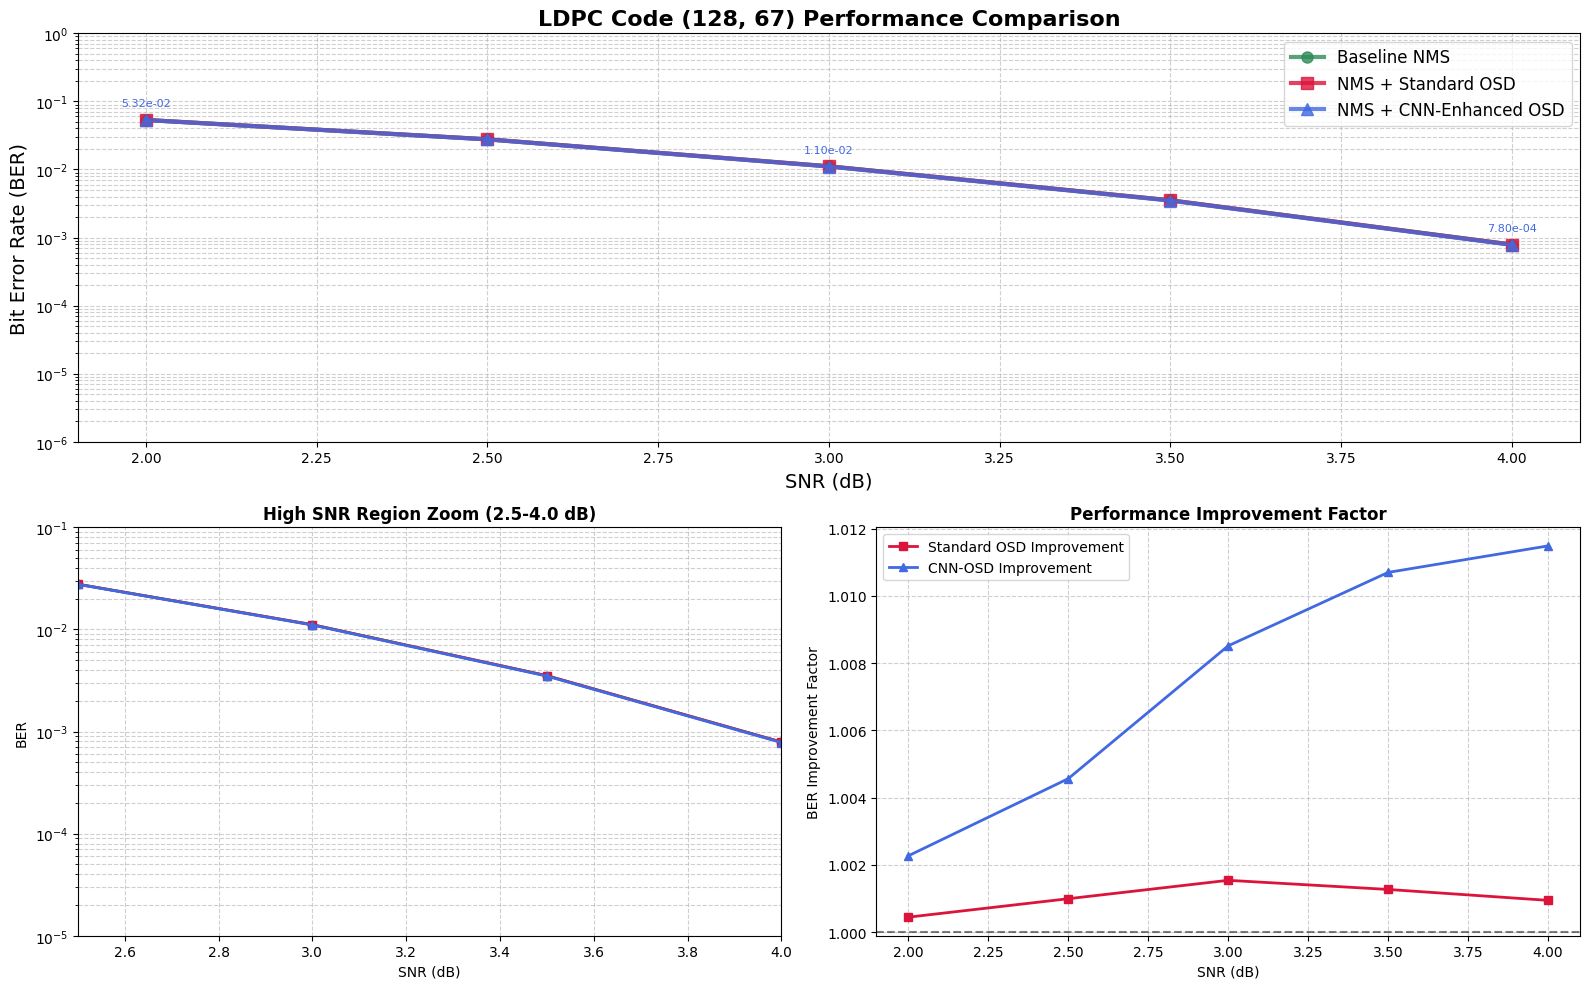


=== Detailed Numerical Comparison ===
SNR(dB)  Baseline     Std OSD      CNN-OSD      Std Impr   CNN Impr  
----------------------------------------------------------------------
2.0      5.34e-02     5.33e-02     5.32e-02     1.00       1.00      
2.5      2.78e-02     2.77e-02     2.76e-02     1.00       1.00      
3.0      1.11e-02     1.11e-02     1.10e-02     1.00       1.01      
3.5      3.53e-03     3.52e-03     3.49e-03     1.00       1.01      
4.0      7.89e-04     7.88e-04     7.80e-04     1.00       1.01      

--> Chart plotting completed!


In [59]:
print("--> Plotting enhanced comparison charts...")

# Create larger figure with multiple subplots to highlight differences
fig = plt.figure(figsize=(16, 10))

# Main plot - Full range BER comparison
ax1 = plt.subplot(2, 2, (1, 2))
ax1.semilogy(snrs_db, ber_baseline, 'o-', label='Baseline NMS', color='#2E8B57', 
             linewidth=3, markersize=8, alpha=0.8)
ax1.semilogy(snrs_db, ber_std_osd, 's-', label='NMS + Standard OSD', color='#DC143C', 
             linewidth=3, markersize=8, alpha=0.8)
ax1.semilogy(snrs_db, ber_cnn_osd, '^-', label='NMS + CNN-Enhanced OSD', color='#4169E1', 
             linewidth=3, markersize=8, alpha=0.8)

ax1.set_title(f'LDPC Code ({n_code}, {k_info}) Performance Comparison', fontsize=16, fontweight='bold')
ax1.set_xlabel('SNR (dB)', fontsize=14)
ax1.set_ylabel('Bit Error Rate (BER)', fontsize=14)
ax1.legend(fontsize=12, loc='upper right')
ax1.grid(True, which="both", ls="--", alpha=0.6)
ax1.set_ylim(1e-6, 1)

# Add numerical annotations
for i, (snr, ber) in enumerate(zip(snrs_db, ber_cnn_osd)):
    if i % 2 == 0:  # Annotate every other point
        ax1.annotate(f'{ber:.2e}', (snr, ber), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=8, color='#4169E1')

# Subplot 1 - High SNR region zoom
ax2 = plt.subplot(2, 2, 3)
ax2.semilogy(snrs_db, ber_baseline, 'o-', color='#2E8B57', linewidth=2, markersize=6)
ax2.semilogy(snrs_db, ber_std_osd, 's-', color='#DC143C', linewidth=2, markersize=6)
ax2.semilogy(snrs_db, ber_cnn_osd, '^-', color='#4169E1', linewidth=2, markersize=6)

ax2.set_title('High SNR Region Zoom (2.5-4.0 dB)', fontsize=12, fontweight='bold')
ax2.set_xlabel('SNR (dB)', fontsize=10)
ax2.set_ylabel('BER', fontsize=10)
ax2.set_xlim(2.5, 4.0)
ax2.set_ylim(1e-5, 1e-1)
ax2.grid(True, which="both", ls="--", alpha=0.6)

# Subplot 2 - Performance improvement comparison
ax3 = plt.subplot(2, 2, 4)
improvement_std = np.array(ber_baseline) / np.array(ber_std_osd)
improvement_cnn = np.array(ber_baseline) / np.array(ber_cnn_osd)

ax3.plot(snrs_db, improvement_std, 's-', label='Standard OSD Improvement', 
         color='#DC143C', linewidth=2, markersize=6)
ax3.plot(snrs_db, improvement_cnn, '^-', label='CNN-OSD Improvement', 
         color='#4169E1', linewidth=2, markersize=6)
ax3.axhline(y=1, color='black', linestyle='--', alpha=0.5)
ax3.set_title('Performance Improvement Factor', fontsize=12, fontweight='bold')
ax3.set_xlabel('SNR (dB)', fontsize=10)
ax3.set_ylabel('BER Improvement Factor', fontsize=10)
ax3.legend(fontsize=10)
ax3.grid(True, which="both", ls="--", alpha=0.6)

plt.tight_layout()
plt.show()

# Print detailed numerical comparison table
print("\n=== Detailed Numerical Comparison ===")
print(f"{'SNR(dB)':<8} {'Baseline':<12} {'Std OSD':<12} {'CNN-OSD':<12} {'Std Impr':<10} {'CNN Impr':<10}")
print("-" * 70)
for i, snr in enumerate(snrs_db):
    std_improve = ber_baseline[i] / ber_std_osd[i] if ber_std_osd[i] > 0 else 0
    cnn_improve = ber_baseline[i] / ber_cnn_osd[i] if ber_cnn_osd[i] > 0 else 0
    print(f"{snr:<8.1f} {ber_baseline[i]:<12.2e} {ber_std_osd[i]:<12.2e} {ber_cnn_osd[i]:<12.2e} "
          f"{std_improve:<10.2f} {cnn_improve:<10.2f}")

print("\n--> Chart plotting completed!")